In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from qbo1d.stochastic_forcing import sample_sf_cw
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [2]:
# data generator:
def data_generator(state=1):
    '''
    Input: state(0~4)
    STATE = 0 -> old control
    STATE = 1 -> new control
    STATE = 2 -> different mean
    STATE = 3 -> different variance
    STATE = 4 -> anti-correlation(non-physical) 

    Output: (u, s, sf, cw, solver)
    '''

    # parameter dicts
    sfe = [3.7e-3, 3.8e-3, 3.2e-3, 3.8e-3, 3.8e-3]
    sfv = [1e-8, 9e-8, 9e-8, 9e-10, 9e-8]
    cwe = [32, 32, 40, 32, 32]
    cwv = [225, 225, 225, 225, 225]
    corr = [0.75, 0.75, 0.75, 0.75, -0.75]
    seed = [int(21*9+8), int(21*9+7), int(21*6+15), int(21*12+5), int(21*2+10)]

    # generate the matrix form

    para_mat = np.array([sfe, sfv, cwe, cwv, corr, seed]).T


    # Load the data manually
    # it takes 40 seconds

    t_max = 360 * 108 * 86400
    nsteps = 360 * 108
    nspinup = 360 * 12
    ntot = int(nsteps - nspinup)

    torch.set_default_dtype(torch.float64)


    # scenario 0 (control)
    # --------------------
    solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
    model = WaveSpectrum(solver, *para_mat[state])
    time = solver.time
    z = solver.z
    u = solver.solve(source_func=model)

    return u, model.s, model.sf, model.cw, solver



In [3]:
STATE = 0
u, s, sf, cw, solver = data_generator(state=STATE)

/Users/eddysmac/Desktop/QBO-1d/qbo1d/adsolver.py:145: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  u[n + 1] = torch.triangular_solve(b, self.R).solution.flatten()


In [126]:
# Data preprocessing
nsteps = 360 * 108
nspinup = 360 * 12


U = u[nspinup:nsteps, :]
SF = sf[nspinup:nsteps]
CW = cw[nspinup:nsteps]

U = torch.hstack([U[:, 1:-1], SF.view(-1, 1), CW.view(-1, 1)])

S = s[nspinup:nsteps, :]

# sc_U = StandardScaler()
sc_U = PCA(n_components=16, whiten=True)
sc_S = StandardScaler()

# Here U is the features and s is the label

# U_train, U_test, s_train, s_test = train_test_split(U, S, test_size=0.8, random_state=42)


U_train, U_test, s_train, s_test = U[2*360:4*360,:], U[4*360:14*360,:], S[2*360:4*360,:], S[4*360:14*360,:]


sc_U.fit(U_train[:, :-2])

def proc_U(X):
    return np.hstack([sc_U.transform(X[:, :-2]), X[:, -2:]])



U_train = proc_U(U_train)
U_test = proc_U(U_test)

s_train = sc_S.fit_transform(s_train)
s_test = sc_S.transform(s_test)



In [166]:
reg = LinearRegression().fit(U[10000:20000], S[10000:20000])
reg.score(U[20000:30000], S[20000:30000])

0.8936309199983961

- The reason why we need scaling: Otherwise we need to set  a really small $\epsilon$ 

In [127]:
s_train_35 = s_train[:, 35]
s_test_35 = s_test[:, 35]

In [144]:
svr = SVR(kernel = 'rbf', gamma='auto', epsilon=.01, C=32)
svr.fit(U_train, s_train_35)

SVR(C=32, epsilon=0.01, gamma='auto')

In [145]:
svr.n_support_

array([587], dtype=int32)

In [146]:
print(svr.score(U_test, s_test_35))
print(svr.score(U_train, s_train_35))

0.8681549063124334
0.9959577667120589


In [147]:
svr_1d = SVR(kernel = 'rbf', gamma='auto', epsilon=.08, C=32)
mr = MultiOutputRegressor(svr)
mr.fit(U_train, s_train)

MultiOutputRegressor(estimator=SVR(C=32, epsilon=0.01, gamma='auto'))

In [148]:
mr.score(U_test, s_test)

0.7672673639657039

In [149]:
prediction = mr.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
# print(f"R-squared: {mr.score(U_test, s_test):.9f}")

The loss of the linear regression: 3.414492424876776


In [150]:
prediction_ = sc_S.inverse_transform(prediction)
s_test_ = sc_S.inverse_transform(s_test)
mean_l2_loss_ = np.linalg.norm((prediction_ - s_test_), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss_}")


The loss of the linear regression: 3.6695537432691896e-05


In [151]:
s_pred = svr.predict(proc_U(U))[500:1000]

In [152]:
scale = sc_S.scale_[35]
me = sc_S.mean_[35]

In [195]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

def model_ML_aug_1(x):
    x = torch.hstack([x[1:-1], sf[solver_ML.current_step], cw[solver_ML.current_step]])
    x = x.reshape(1, 73)
    x = proc_U(x)
    y = mr.predict(x)
    y = sc_S.inverse_transform(y)
    
    return torch.tensor(y[0])

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))

def model_ML_aug_2(x):
    x = torch.hstack([x[1:-1], sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]])
    x = x.reshape(1, 73)
    return torch.tensor(reg.predict(x))[0]

model_ML_aug = lambda x: .5 * model_ML_aug_1(x) + .5 * model_ML_aug_2(x) 

u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [196]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

In [197]:
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    return ax_pos_absolute

def plot_76_tensors(u, solver, amp25=None, amp20=None, period=None, isu=True):
    fig_size = (06.90, 02.20+01.50)
    fig = plt.figure(figsize=fig_size)

    ax = []

    ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

    cmin = -u.abs().max()
    cmax = u.abs().max()

    xmin = 84.
    xmax = 96.
    ymin = 17.
    ymax = 35.

    ax[0].set_xlim(left=84.)
    ax[0].set_xlim(right=96.)
    ax[0].set_ylim(bottom=17.)
    ax[0].set_ylim(top=35.)

    h = []

    h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

    ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
    ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

    ax[0].set_ylabel('Km', fontsize=10)

    ax[0].set_xlabel('model year', fontsize=10)

    xticks_list = np.arange(xmin, xmax+1, 1)
    ax[0].set_xticks(xticks_list)

    yticks_list = np.arange(ymin, ymax+2, 2)
    ax[0].set_yticks(yticks_list)

    xticklabels_list = list(xticks_list)
    xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
    ax[0].set_xticklabels(xticklabels_list, fontsize=10)

    ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
    ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
    ax[0].tick_params(which='both', labelbottom=True)

    if isu:
        ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %period + 'months',
        horizontalalignment='left', verticalalignment='bottom', color='black')

    # # colorbars
    if isu:
        label = r'$\mathrm{m s^{-1}}$'
    else:
        label = r'$\mathrm{m s^{-2}}$'
    
    cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
    ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
    boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
    label=label)


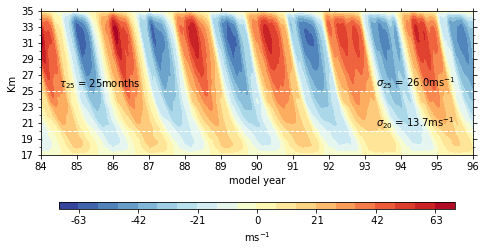

In [198]:
plot_76_tensors(u_ML, solver_ML, amp20=amp20_ML, amp25=amp25_ML, period=tau25_ML)

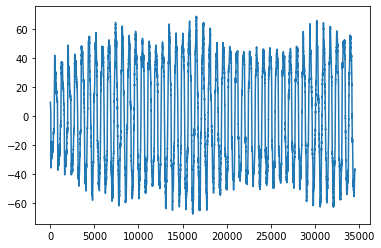

In [199]:
plt.plot(u_ML[:, 56])

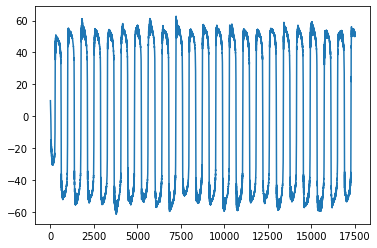

In [200]:
plt.plot(u[:17500, 56])